# Nosana: Run Stable Diffusion models with accessible GPUs


Stable Diffusion is a powerful, open-source deep learning model that can generate detailed images from text descriptions (text-to-image), modify existing images based on text (image-to-image), and much more. It's a type of **latent diffusion model** that works by first encoding an image into a lower-dimensional *latent space*, adding noise, and then using a model to predict and remove that noise, guided by your text prompt.

In this notebook, we'll cover the fundamental concepts and provide clear, concise code to get you started. We'll explore:

1.  **Setup**: Installing libraries and loading API keys.
2.  **Text-to-Image (txt2img)**: Creating images purely from text prompts.
3.  **Image-to-Image (img2img)**: Modifying an existing image with a text prompt.
4.  **Depth-to-Image**: A more advanced technique that uses an image's depth map to guide generation.

Let's get started!

`## 1. Setup

For GPU-heavy workloads such as image generation, you can easily create a Jupyter Notebook environment using Nosana.

All you need to do is go to the [Nosana dashboard](!https://dashboard.nosana.com/deploy) and select the **Pytorch Jupyter Notebook** template:

```
docker.io/nosana/pytorch-jupyter:2.0.0
```

This will spin up a Jupyter Notebook environment with GPU support, perfect for running Stable Diffusion and other deep learning models.

**Tip:** If you want to run the Jupyter Notebook UI locally or through VS Code, simply copy and paste the Nosana Base URL as the Kernel URL in your Notebook. This allows you to use the remote GPU resources from Nosana while working in your preferred local environment.

Next, install the necessary Python libraries. `diffusers` is the core library from Hugging Face for working with diffusion models. `transformers` is needed for the text-processing components, `accelerate` helps to speed up the process, and `python-dotenv` allows us to securely manage our API keys.

You also need to create a `.env` file in the same directory as this notebook. This file will store your Hugging Face API token, which is required to download the pre-trained models. Add the following line to your `.env` file:

```
HUGGINGFACE_ACCESS_TOKEN='your_api_key_here'
````

In [3]:
#%pip install diffusers transformers accelerate python-dotenv Pillow -q

In [7]:
# Install ipywidgets for tqdm progress bars in Jupyter
# %pip install ipywidgets --upgrade -q

In [ ]:
import torch
from diffusers import AutoPipelineForText2Image, AutoPipelineForImage2Image, StableDiffusionDepth2ImgPipeline
from PIL import Image
import requests
from dotenv import load_dotenv
import os

# Create an .env file and echo your token into the file
load_dotenv()
api_key = os.getenv("HUGGINGFACE_ACCESS_TOKEN")

# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

print(f"Using device: {device}")

Using device: cuda


## 2. Text-to-Image (txt2img)

This is the most common use of Stable Diffusion: creating an image from a text description. The process involves providing a **prompt** (what you want to see) and, optionally, a **negative prompt** (what you want to avoid).

Key parameters:
- **`prompt`**: A string describing the desired image.
- **`negative_prompt`**: A string of terms to exclude from the image.
- **`num_inference_steps`**: The number of denoising steps. More steps can lead to higher quality but take longer. A value between 25-50 is often a good balance.
- **`guidance_scale`**: How much the model should adhere to the prompt. Higher values mean stricter adherence. Typically, a value around 7.5 works well.

Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]

100%|██████████| 30/30 [00:03<00:00,  8.24it/s]



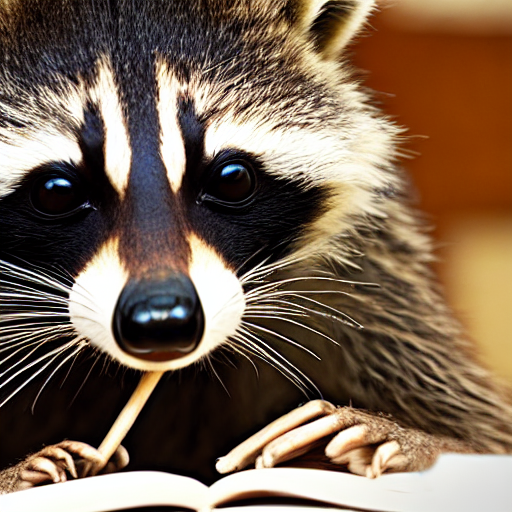

In [14]:
# Authenticate with Hugging Face Hub
from huggingface_hub import login
login(token=api_key)

# Load the text-to-image pipeline with authentication
txt2img_pipe = AutoPipelineForText2Image.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", 
    torch_dtype=torch_dtype, 
    use_safetensors=True,
    token=api_key
).to(device)

# Define the prompt and generate the image
prompt = "A cinematic shot of a raccoon in a library, wearing a monocle, detailed, 8k"
negative_prompt = "blurry, low quality, deformed, ugly"

image = txt2img_pipe(
    prompt=prompt, 
    negative_prompt=negative_prompt, 
    num_inference_steps=30, 
    guidance_scale=7.5
).images[0]

# Display the image
image

## 3. Image-to-Image (img2img)

Image-to-image allows you to provide an initial image and a prompt to guide its transformation. This is great for restyling an image or changing its content while preserving the overall composition.

The key new parameter is:
- **`strength`**: A value between 0.0 and 1.0 that controls how much the original image is altered. A lower value preserves more of the original image, while a higher value gives the model more creative freedom.

Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]

100%|██████████| 37/37 [00:08<00:00,  4.34it/s]



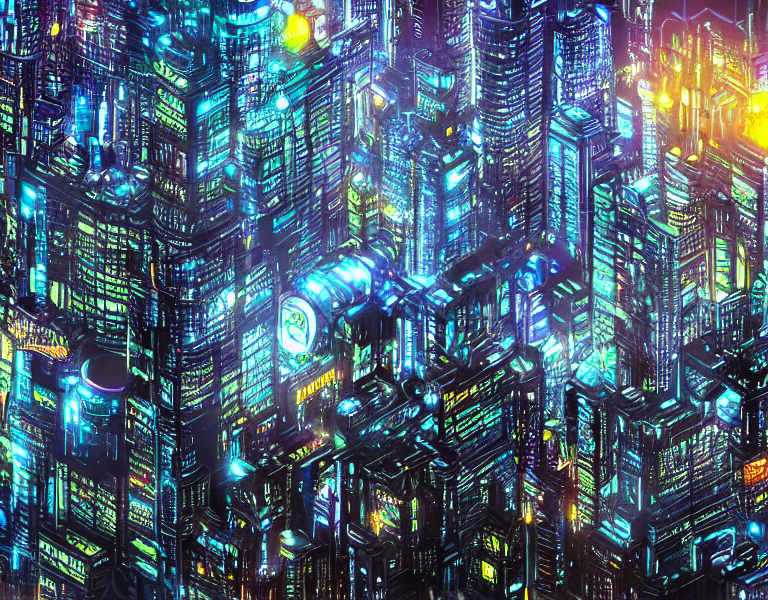

In [15]:
# Load the image-to-image pipeline
img2img_pipe = AutoPipelineForImage2Image.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", 
    torch_dtype=torch_dtype, 
    use_safetensors=True
).to(device)

# Load an initial image from a URL
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"
init_image = Image.open(requests.get(url, stream=True).raw).resize((768, 600))

prompt = "A futuristic cityscape at night, high-tech, neon lights, in the style of Blade Runner"

# Generate the new image
image = img2img_pipe(
    prompt=prompt,
    image=init_image,
    strength=0.75,
    guidance_scale=7.5
).images[0]

# Display the transformed image
image

## 4. Depth-to-Image

Depth-to-image is an advanced technique where the model uses the depth information from an initial image to generate a new one. This is incredibly powerful for maintaining the 3D structure and composition of the original scene while completely changing the style and objects within it.

The model first estimates a **depth map** from the input image and then uses it, along with your prompt, to guide the generation process.

Loading pipeline components...: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]

100%|██████████| 35/35 [00:06<00:00,  5.11it/s]


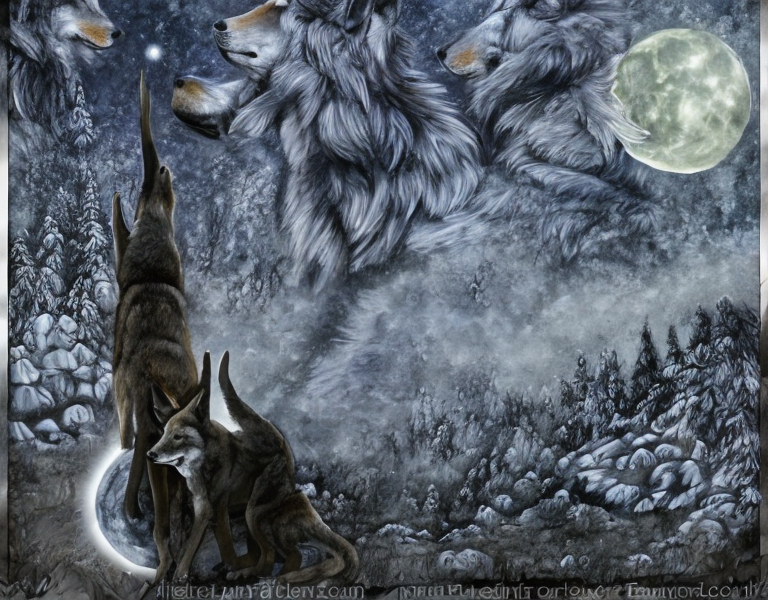

In [13]:
# Load the depth-to-image pipeline
depth_pipe = StableDiffusionDepth2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-depth",
    torch_dtype=torch_dtype,
).to(device)

# Use the same initial image
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"
init_image = Image.open(requests.get(url, stream=True).raw).resize((768, 600))

prompt = "Two majestic wolves howling at the moon, fantasy art, detailed"

# Generate the new image using depth information
image = depth_pipe(
    prompt=prompt, 
    image=init_image, 
    strength=0.7
).images[0]

# Display the result
image

## Conclusion

Congratulations! You've successfully generated images using Stable Diffusion with three different techniques.

We've covered the basics, but there's a whole world to explore:
- **Prompt Engineering**: Experiment with highly detailed prompts, artist names, and styles.
- **Different Models**: The Hugging Face Hub has thousands of custom-trained models for specific styles (e.g., anime, photorealism).
- **Schedulers**: The `diffusers` library allows you to swap out different schedulers, which can affect the speed and quality of image generation.
- **GPU Resources**: With Nosana, you can easily access powerful GPU resources for running Stable Diffusion and other deep learning workloads, whether in the cloud or by connecting your local notebook to a remote kernel.

Happy diffusing! 🎉